## Notebook to fit triple orbits with astrometry + rv

In [598]:
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm import tqdm
import matplotlib.cm as cm
from read_data import read_data,read_rv,read_wds,read_orb6
from astrometry_model import astrometry_model,astrometry_model_vlti,rv_model,rv_model_circular,triple_model,triple_model_circular,triple_model_combined,triple_model_vlti_combined,triple_model_vlti,triple_model_combined_circular,lnlike,lnprior,lnpost,create_init
from orbit_plotting import orbit_model,triple_orbit_model
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import random
from PyAstronomy.pyasl import foldAt
from PyAstronomy import pyasl
ks=pyasl.MarkleyKESolver()

%matplotlib inline

In [599]:
## setup paths for user
path = '/Users/tgardne/ARMADA_orbits'
path_etalon = '/Users/tgardne/etalon_epochs/etalon_fits/etalon_factors_fit.txt'
path_wds = '/Users/tgardne/ARMADA_orbits'
path_orb6 = '/Users/tgardne/catalogs/orb6orbits.sql.txt'

In [600]:
## Specify target
target_hd = '199766' ## HD number
note = 'rv' ## note for saved file
corrected = 'n' ## bootstrap errors?

In [601]:
query = Simbad.query_objectids('HD %s'%target_hd)
for item in query:
    if 'HIP' in item[0]:
        target = item[0].split()[1]
        print('HIP %s'%target)
    if 'WDS' in item[0]:
        target_wds = item[0][5:15]
        print('WDS %s'%target_wds)

HIP 103569
WDS 20591+0418


In [602]:
###########################################
## Read in ARMADA data
###########################################
if corrected == 'y':
    print('reading boostrap errors')
    file=open('%s/HD_%s_bootstrap.txt'%(path,target_hd))
else:
    print('reading chi2 errors')
    file=open('%s/HD_%s_chi2err_edited.txt'%(path,target_hd))
weight=1

t,p,theta,error_maj,error_min,error_pa,error_deg = read_data(file,weight)
file.close()

file_rv=open('%s/HD_%s_rv.txt'%(path,target_hd))

weight_rv = 2 ## km/s error

t_rv,rv,err_rv = read_rv(file_rv,weight_rv)
file_rv.close()

reading chi2 errors


In [603]:
### correct PAs based on precession
coord = SkyCoord.from_name("HD %s"%target_hd,parse=True)
ra = coord.ra.value*np.pi/180
dec = coord.dec.value*np.pi/180
#theta -= (0.00557*np.sin(ra)/np.cos(dec)*((t-51544.5)/365.25))/180*np.pi

In [604]:
###########################################
## Apply etalon correction
###########################################
file=open(path_etalon)
mjd_etalon=[]
f_etalon=[]
for line in file.readlines():
    if line.startswith('#'):
        continue
    mjd_etalon.append(float(line.split()[0]))
    f_etalon.append(float(line.split()[1]))
file.close()
mjd_etalon=np.array(mjd_etalon)
f_etalon=np.array(f_etalon)

etalon_factor=[]
for i in t:
    idx = np.where(abs(i-mjd_etalon)==min(abs(i-mjd_etalon)))
    if min(abs(i-mjd_etalon))>0.5:
        print('Closest factor for %s is %s days away'%(i,min(abs(i-mjd_etalon))))
    f = f_etalon[idx][0]
    etalon_factor.append(f)
etalon_factor=np.array(etalon_factor)

print('   date      etalon factor')
for i,j in zip(t,etalon_factor):
    print(i,j)

   date      etalon factor
59375.4149 1.0000934683730796
59343.5131 1.000134194670288
59341.5142 1.0001541581756503
59152.1885 0.9999506439916728
59044.3511 0.9999818596048238
59043.3454 1.0000108127617482
59076.3039 0.9999013196052562
58799.1387 0.9997126254032008
58695.3083 0.9997802599398803
58701.2595 0.9997296699476363
58696.2998 0.9998430155145915
59155.1875 0.9998978818767915


In [605]:
## set etalon factors to 1 for vlti data
vlti = 'n'
if vlti=='y':
    vlti_idx = input('enter indices (e.g. 1 2 3): ').split(' ')
    vlti_idx = np.array([int(i) for i in vlti_idx])
else:
    vlti_idx = []
    
## Apply etalon
etalon = 'y'
if etalon=='y':
    print('Applying etalon correction')
    if len(vlti_idx)>0:
        print('Setting VLTI correction factors to 1.0')
        etalon_factor[vlti_idx] = 1.0
    p = p/etalon_factor
else:
    print('No etalon correction applied')

Applying etalon correction


In [606]:
xpos=p*np.sin(theta)
ypos=p*np.cos(theta)

vlti_mask = np.ones(len(t),dtype=bool)
vlti_mask[vlti_idx] = False

Number of WDS data points = 64


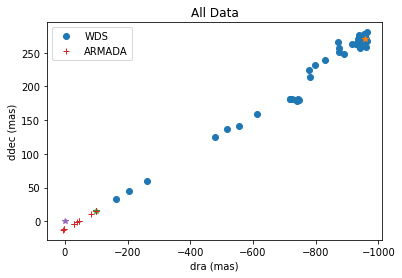

Flip WDS data? (y/n):  n


In [607]:
###########################################
## Read in WDS data - and plot to check
###########################################
input_wds = 'y'
if input_wds == 'y':
    file=open(os.path.expanduser("%s/HD%s_chi2err/HD_%s_wds.txt"%(path_wds,target_hd,target_hd)))
    weight = 1
    t_wds,p_wds,theta_wds,error_maj_wds,error_min_wds,error_pa_wds,error_deg_wds = read_data(file,weight)
    print('Number of WDS data points = %s'%len(p_wds))

    ## correct WDS for PA
    #theta_wds -= (0.00557*np.sin(ra)/np.cos(dec)*((t_wds-51544.5)/365.25))/180*np.pi

    xpos_wds=p_wds*np.sin(theta_wds)
    ypos_wds=p_wds*np.cos(theta_wds)
    idx = np.argmin(t)

    plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
    plt.plot(xpos_wds[0],ypos_wds[0],'*')
    plt.plot(xpos[idx],ypos[idx],'*')
    if len(vlti_idx)>0:
        plt.plot(xpos[vlti_mask],ypos[vlti_mask],'+',label='ARMADA-CHARA')
        plt.plot(xpos[vlti_idx],ypos[vlti_idx],'+',label='ARMADA-VLTI')
    else:
        plt.plot(xpos,ypos,'+',label='ARMADA')
    plt.plot(0,0,'*')
    plt.gca().invert_xaxis()
    plt.title('All Data')
    plt.xlabel('dra (mas)')
    plt.ylabel('ddec (mas)')
    plt.legend()
    plt.show()

    flip = input('Flip WDS data? (y/n): ')
    if flip=='y':
        xpos_wds=-p_wds*np.sin(theta_wds)
        ypos_wds=-p_wds*np.cos(theta_wds)
        plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
        plt.plot(xpos_wds[0],ypos_wds[0],'*')
        plt.plot(xpos[idx],ypos[idx],'*')
        plt.plot(xpos,ypos,'+',label='ARMADA')
        plt.plot(0,0,'*')
        plt.gca().invert_xaxis()
        plt.title('All Data')
        plt.xlabel('dra (mas)')
        plt.ylabel('ddec (mas)')
        plt.legend()
        plt.show()

        better = input('Flip data back to original? (y/n): ')
        if better=='y':
            xpos_wds=p_wds*np.sin(theta_wds)
            ypos_wds=p_wds*np.cos(theta_wds)
else:
    t_wds = np.array([np.nan])
    p_wds = np.array([np.nan])
    theta_wds = np.array([np.nan])
    error_maj_wds = np.array([np.nan])
    error_min_wds = np.array([np.nan])
    error_pa_wds = np.array([np.nan])
    error_deg_wds = np.array([np.nan])
    xpos_wds=p_wds*np.sin(theta_wds)
    ypos_wds=p_wds*np.cos(theta_wds)
    print('NO WDS DATA')

In [608]:
###########################################
## Get an estimate of the orbital parameters
###########################################
try:
    a,P,e,inc,omega,bigomega,T = read_orb6(target,path_orb6)
except:
    print('No elements found in ORB6')
    
self_params = 'y'
if self_params=='y':
    a = float(input('a (mas): '))
    P = float(input('P (year): '))*365.25
    e = float(input('ecc : '))
    inc = float(input('inc (deg): '))
    omega = float(input('omega (deg): '))
    bigomega = float(input('bigomega (deg): '))
    T = float(input('T (mjd): '))

found target!
--------------------------
a(mas),P(yr),e,i(deg),omega(deg),bigomega(deg),T(mjd)
647.4 101.485 0.705 92.17 340.19 105.15 22459.793613999966
--------------------------


a (mas):  595
P (year):  99
ecc :  0.7
inc (deg):  92
omega (deg):  349
bigomega (deg):  106
T (mjd):  24366


In [609]:
###########################################
## Combined WDS+ARMADA for fitting
###########################################
xpos_all = np.concatenate([xpos,xpos_wds])
ypos_all = np.concatenate([ypos,ypos_wds])
t_all = np.concatenate([t,t_wds])
error_maj_all = np.concatenate([error_maj,error_maj_wds])
error_min_all = np.concatenate([error_min,error_min_wds])
error_pa_all = np.concatenate([error_pa,error_pa_wds])
error_deg_all = np.concatenate([error_deg,error_deg_wds])

vlti_mask_all = np.ones(len(t_all),dtype=bool)
vlti_mask_all[vlti_idx] = False

In [610]:
##########################################
## Function for fitting/plotting data
#########################################
def ls_fit(params,xp,yp,tp,emaj,emin,epa):
    #do fit, minimizer uses LM for least square fitting of model to data
    if len(vlti_idx)>0:
        minner = Minimizer(astrometry_model_vlti, params, fcn_args=(xp[vlti_mask_all],yp[vlti_mask_all],tp[vlti_mask_all],
                                                        emaj[vlti_mask_all],emin[vlti_mask_all],epa[vlti_mask_all],
                                                        xp[vlti_idx],yp[vlti_idx],tp[vlti_idx],
                                                        emaj[vlti_idx],emin[vlti_idx],epa[vlti_idx]),
                                nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(astrometry_model, params, fcn_args=(xp,yp,tp,
                                                        emaj,emin,epa),
                                nan_policy='omit')
        result = minner.minimize()

    # write error report
    print(report_fit(result))

    resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                                 error_min,error_pa)
    ndata_armada = 2*sum(~np.isnan(xpos))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-7)
    print('-'*10)
    print('chi2 armada = %s'%chi2_armada)
    print('-'*10)

    ## plot fit
    scale=1
    if chi2_armada<1.0 and chi2_armada>0:
        scale=1/np.sqrt(chi2_armada)
    a_start = result.params['a']
    P_start = result.params['P']
    e_start = result.params['e']
    inc_start = result.params['inc']
    w_start = result.params['w']
    bigw_start = result.params['bigw']
    T_start = result.params['T']
    mirc_scale_start = result.params['mirc_scale']

    ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                            w_start,bigw_start,P_start,
                                            T_start,t_all)
    fig,ax=plt.subplots()
    ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
    if len(vlti_idx)>0:
        ax.plot(xpos[vlti_idx]*mirc_scale_start,ypos[vlti_idx]*mirc_scale_start,'o', label='ARMADA-VLTI')
        ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
    else:
        ax.plot(xpos,ypos,'o', label='ARMADA')
    ax.plot(0,0,'*')
    ax.plot(ra, dec, '--',color='g')
    #plot lines from data to best fit orbit
    i=0
    while i<len(decpoints):
        x=[xpos_all[i],rapoints[i]]
        y=[ypos_all[i],decpoints[i]]
        ax.plot(x,y,color="black")
        i+=1
    ax.set_xlabel('milli-arcsec')
    ax.set_ylabel('milli-arcsec')
    ax.invert_xaxis()
    ax.axis('equal')
    ax.set_title('HD%s Outer Orbit'%target_hd)
    plt.legend()
    plt.show()

    return result

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 144
    # variables        = 7
    chi-square         = 1679.33021
    reduced chi-square = 12.2578847
    Akaike info crit   = 367.712529
    Bayesian info crit = 388.501222
[[Variables]]
    w:           353.326684 +/- 9.86120545 (2.79%) (init = 349)
    bigw:        106.114655 +/- 0.16729064 (0.16%) (init = 106)
    inc:         92.3015540 +/- 0.09219901 (0.10%) (init = 92)
    e:           0.72033508 +/- 0.01393906 (1.94%) (init = 0.7)
    a:           584.161804 +/- 19.3787980 (3.32%) (init = 595)
    P:           34764.2456 +/- 4344.36816 (12.50%) (init = 36159.75)
    T:           25822.1752 +/- 4364.81314 (16.90%) (init = 24366)
    mirc_scale:  1 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(P, T)      = -1.000
    C(w, P)      = -0.997
    C(w, T)      =  0.996
    C(w, bigw)   =  0.995
    C(a, P)      =  0.993
    C(a, T)      = -0.993
    C(bigw, 

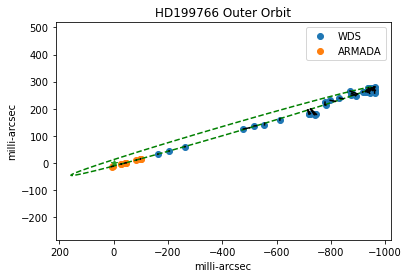

In [611]:
###########################################
## Do a least-squares fit
###########################################
params = Parameters()
params.add('w',   value= omega, min=0, max=360)
params.add('bigw', value= bigomega, min=0, max=360)
params.add('inc', value= inc, min=0, max=180)
params.add('e', value= e, min=0, max=0.99)
params.add('a', value= a, min=0)
params.add('P', value= P, min=0)
params.add('T', value= T, min=0)
if len(vlti_idx)>0:
    params.add('mirc_scale', value=1)
else:
    params.add('mirc_scale',value=1,vary=False)

result = ls_fit(params,xpos_all,ypos_all,t_all,error_maj_all,error_min_all,error_pa_all)

----------
chi2 armada = 93.70400864468762
----------


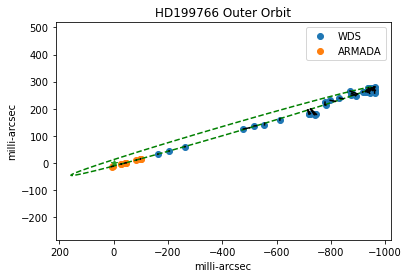

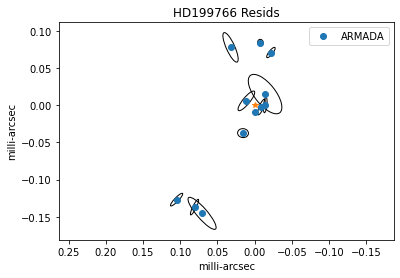

----------
Mean residual = 57.36 micro-as
----------


In [612]:
##########################################
## Save Plots
##########################################
if len(vlti_idx)>0:
    resids_armada = astrometry_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
else:
    resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
ndata_armada = 2*sum(~np.isnan(xpos))
chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-7)
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

if corrected == 'y':
    directory='%s/HD%s_bootstrap_triple/'%(path,target_hd)
else:
    directory='%s/HD%s_chi2err_triple/'%(path,target_hd)
if not os.path.exists(directory):
    os.makedirs(directory)

## plot fit
scale=1
if chi2_armada<1.0 and chi2_armada>0:
    scale=1/np.sqrt(chi2_armada)
a_start = result.params['a']
P_start = result.params['P']
e_start = result.params['e']
inc_start = result.params['inc']
w_start = result.params['w']
bigw_start = result.params['bigw']
T_start = result.params['T']
mirc_scale_start = result.params['mirc_scale']
ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                        w_start,bigw_start,P_start,
                                        T_start,t_all)
fig,ax=plt.subplots()
ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx]*mirc_scale_start,ypos[vlti_idx]*mirc_scale_start,'o', label='ARMADA-VLTI')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xpos,ypos,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')
#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_outer_binary.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## plot resids for ARMADA
fig,ax=plt.subplots()
if len(vlti_idx)>0:
    xresid_vlti = xpos[vlti_idx]*mirc_scale_start - rapoints[:len(xpos)][vlti_idx]
    yresid_vlti = ypos[vlti_idx]*mirc_scale_start - decpoints[:len(ypos)][vlti_idx]
    xresid_chara = xpos[vlti_mask] - rapoints[:len(xpos)][vlti_mask]
    yresid_chara = ypos[vlti_mask] - decpoints[:len(ypos)][vlti_mask]
    xresid = np.concatenate([xresid_chara,xresid_vlti])
    yresid = np.concatenate([yresid_chara,yresid_vlti])
else:
    xresid = xpos - rapoints[:len(xpos)]
    yresid = ypos - decpoints[:len(ypos)]

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle in zip(xresid,yresid,error_maj/scale,error_min/scale,error_deg):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

if len(vlti_idx)>0:
    ax.plot(xresid[vlti_idx],yresid[vlti_idx],'o', label='ARMADA-VLTI')
    ax.plot(xresid[vlti_mask],yresid[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xresid,yresid,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Resids'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_resid_binary.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## residuals
resids = np.sqrt(xresid**2 + yresid**2)
resids_median = np.around(np.median(resids)*1000,2)
print('-'*10)
print('Mean residual = %s micro-as'%resids_median)
print('-'*10)

## Save txt file with best orbit
f = open("%s/%s_%s_orbit_binary.txt"%(directory,target_hd,note),"w+")
f.write("# P(d) a(mas) e i(deg) w(deg) W(deg) T(mjd) mirc_scale mean_resid(mu-as)\r\n")
f.write("%s %s %s %s %s %s %s %s %s"%(P_start.value,a_start.value,e_start.value,
                                   inc_start.value*180/np.pi,w_start.value*180/np.pi,
                                   bigw_start.value*180/np.pi,T_start.value,
                                  mirc_scale_start.value,resids_median))
f.close()

In [613]:
##########################################
## User input for additional companions
##########################################
P2 = 2.04
a2 = 0.08
inc2 = 90
circular = 'n'

In [614]:
P2_best = []
a2_best = []
e2_best = []
w2_best = []
bigw2_best = []
inc2_best = []
T2_best = []
P_best = []
a_best = []
e_best = []
w_best = []
bigw_best = []
inc_best = []
T_best = []
mirc_scale_best = []
chi2_results = []

K_best = []
gamma_best = []

for i in tqdm(np.arange(100)):
    bigw2 = random.uniform(0,360)
    T2 = random.uniform(57000,59000)
    K = random.uniform(-50,50)
    gamma = random.uniform(-30,30)
    if circular!='y':
        e2 = random.uniform(0,0.99)
        w2 = random.uniform(0,360)

    params = Parameters()
    if circular=='y':
        params.add('e2',value=0,vary=False)
        params.add('w2',value=0,vary=False)
    else:
        params.add('e2',value=e2,min=0,max=0.99)
        params.add('w2',value=w2,min=0,max=360)
    params.add('w',   value= w_start, min=0, max=360)
    params.add('bigw', value= bigw_start, min=0, max=360)
    params.add('inc', value= inc_start, min=0, max=180)
    params.add('e', value= e_start, min=0, max=0.99)
    params.add('a', value= a_start, min=0)
    params.add('P', value= P_start, min=0)
    params.add('T', value= T_start, min=0)
    params.add('bigw2', value= bigw2, min=0, max=360)
    params.add('inc2', value= inc2, min=0, max=180)
    params.add('a2', value= a2, min=0)
    params.add('P2', value= P2, min=0)
    params.add('T2', value= T2, min=0)
    params.add('K',value=K)
    params.add('gamma',value=gamma)
    if len(vlti_idx)>0:
        params.add('mirc_scale', value=1)
    else:
        params.add('mirc_scale',value=1,vary=False)

    #do fit, minimizer uses LM for least square fitting of model to data
    if len(vlti_idx)>0:
        minner = Minimizer(triple_model_vlti_combined, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                            error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                            error_pa_all[vlti_mask_all],
                                                            xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                            error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                            error_pa_all[vlti_idx],rv,t_rv,err_rv),
                            nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(triple_model_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                            error_maj_all,error_min_all,
                                                            error_pa_all,rv,t_rv,err_rv),
                            nan_policy='omit')
        result = minner.minimize()
    #try:
    #    print(report_fit(result))
    #except:
    #    print('No fit report')

    P2_best.append(result.params['P2'])
    a2_best.append(result.params['a2'])
    e2_best.append(result.params['e2'])
    w2_best.append(result.params['w2'])
    bigw2_best.append(result.params['bigw2'])
    inc2_best.append(result.params['inc2'])
    T2_best.append(result.params['T2'])
    P_best.append(result.params['P'])
    a_best.append(result.params['a'])
    e_best.append(result.params['e'])
    w_best.append(result.params['w'])
    bigw_best.append(result.params['bigw'])
    inc_best.append(result.params['inc'])
    T_best.append(result.params['T'])
    K_best.append(result.params['K'])
    gamma_best.append(result.params['gamma'])
    mirc_scale_best.append(result.params['mirc_scale'])
    chi2_results.append(result.redchi)
P2_best = np.array(P2_best)
a2_best = np.array(a2_best)
e2_best = np.array(e2_best)
w2_best = np.array(w2_best)
bigw2_best = np.array(bigw2_best)
inc2_best = np.array(inc2_best)
T2_best = np.array(T2_best)
P_best = np.array(P_best)
a_best = np.array(a_best)
e_best = np.array(e_best)
w_best = np.array(w_best)
bigw_best = np.array(bigw_best)
inc_best = np.array(inc_best)
T_best = np.array(T_best)
K_best = np.array(K_best)
gamma_best = np.array(gamma_best)
mirc_scale_best = np.array(mirc_scale_best)
chi2_results = np.array(chi2_results)

idx = np.argmin(chi2_results)
P2_best = P2_best[idx]
a2_best = a2_best[idx]
e2_best = e2_best[idx]
w2_best = w2_best[idx]
bigw2_best = bigw2_best[idx]
inc2_best = inc2_best[idx]
T2_best = T2_best[idx]
P_best = P_best[idx]
a_best = a_best[idx]
e_best = e_best[idx]
w_best = w_best[idx]
bigw_best = bigw_best[idx]
inc_best = inc_best[idx]
T_best = T_best[idx]
K_best = K_best[idx]
gamma_best = gamma_best[idx]
mirc_scale_best = mirc_scale_best[idx]

100%|██████████| 100/100 [26:23<00:00, 15.84s/it] 


In [615]:
##########################################
## Save Plots for Triple
##########################################
if len(vlti_idx)>0:
    resids_armada = triple_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
else:
    resids_armada = triple_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
ndata_armada = 2*sum(~np.isnan(xpos))
if circular=='y':
    print(ndata_armada)
    print(len(result.params))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-12)
else:
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-14)
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

----------
chi2 armada = 25.14723493257889
----------


In [616]:
if len(vlti_idx)>0:
    xpos[vlti_idx]*=mirc_scale_best
    ypos[vlti_idx]*=mirc_scale_best
    xpos_all[vlti_idx]*=mirc_scale_best
    ypos_all[vlti_idx]*=mirc_scale_best
else:
    idx = np.where(t<58757)
    xpos[idx]/=mirc_scale_best
    ypos[idx]/=mirc_scale_best
    idx = np.where(t_all<58757)
    xpos_all[idx]/=mirc_scale_best
    ypos_all[idx]/=mirc_scale_best

## plot fit
scale=1
if chi2_armada<1.0 and chi2_armada>0:
    scale=1/np.sqrt(chi2_armada)
else:
    scale=float(input('scale errors by: '))

ra,dec,rapoints,decpoints = triple_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,t_all)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all)

scale errors by:  1


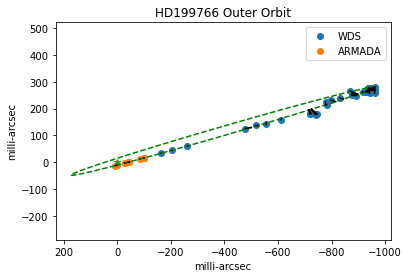

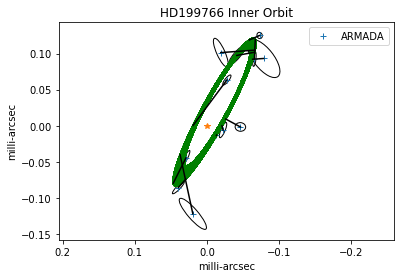

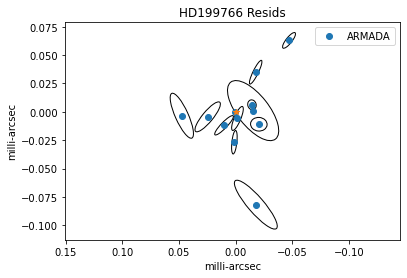

----------
Mean residual = 24.12 micro-as
----------


In [617]:
fig,ax=plt.subplots()
ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx],ypos[vlti_idx],'o', label='ARMADA-VLTI')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xpos,ypos,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')
#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_outer_triple.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## plot inner wobble
#idx = np.where(error_maj/scale<1)
ra_inner = ra - ra2
dec_inner = dec - dec2
rapoints_inner = rapoints - rapoints2
decpoints_inner = decpoints - decpoints2

xpos_inner = xpos_all - rapoints2
ypos_inner = ypos_all - decpoints2

fig,ax=plt.subplots()
if len(vlti_idx)>0:
    ax.plot(xpos_inner[:len(xpos)][vlti_idx],ypos_inner[:len(xpos)][vlti_idx],'+', label='ARMADA-VLTI')
    ax.plot(xpos_inner[:len(xpos)][vlti_mask],ypos_inner[:len(xpos)][vlti_mask],'+', label='ARMADA-CHARA')
else:
    ax.plot(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],'+', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra_inner, dec_inner, '--',color='g')

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle in zip(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],error_maj/scale,error_min/scale,error_deg):
    #if w<0.05:
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                        angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints_inner[:len(xpos)]):
    x=[xpos_inner[:len(xpos)][i],rapoints_inner[:len(xpos)][i]]
    y=[ypos_inner[:len(xpos)][i],decpoints_inner[:len(xpos)][i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_inner_triple.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## plot resids for ARMADA
fig,ax=plt.subplots()
xresid = xpos - rapoints[:len(xpos)]
yresid = ypos - decpoints[:len(ypos)]

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle in zip(xresid,yresid,error_maj/scale,error_min/scale,error_deg):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

if len(vlti_idx)>0:
    ax.plot(xresid[vlti_idx],yresid[vlti_idx],'o', label='ARMADA-VLTI')
    ax.plot(xresid[vlti_mask],yresid[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xresid,yresid,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Resids'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_resid_triple.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## residuals
resids = np.sqrt(xresid**2 + yresid**2)
resids_median = np.around(np.median(resids)*1000,2)
print('-'*10)
print('Mean residual = %s micro-as'%resids_median)
print('-'*10)

## Save txt file with best orbit
f = open("%s/%s_%s_orbit_triple.txt"%(directory,target_hd,note),"w+")
f.write("# P(d) a(mas) e i(deg) w(deg) W(deg) T(mjd) P2 a2 e2 i2 w2 W2 T2 mirc_scale K gamma mean_resid(mu-as)\r\n")
f.write("%s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s"%(P_best,
                                    a_best,e_best,
                                   inc_best,w_best,
                                   bigw_best,T_best,
                                   P2_best,a2_best,e2_best,
                                   inc2_best,w2_best,
                                   bigw2_best,T2_best,
                                  mirc_scale_best,K_best,
                                  gamma_best,resids_median))
f.close()

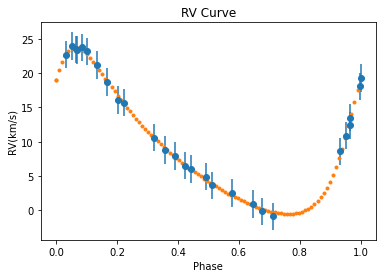

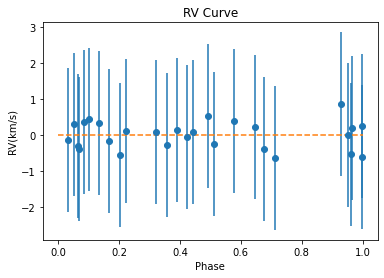

In [529]:
#Plot RV results:
w2_rv = w2_best*np.pi/180+np.pi
foldtime= foldAt(t_rv,P2_best,T0=T2_best)
tt=np.linspace(T2_best,T2_best+P2_best,100)
MM=[]
for i in tt:
    mm_anom=2*np.pi/P2_best*(i-T2_best)
    MM.append(mm_anom)
MM=np.asarray(MM)
EE=[]
for j in MM:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e2_best)
    EE.append(ee_anom)
EE=np.asarray(EE)
MM2=[]
for i in t_rv:
    mm_anom=2*np.pi/P2_best*(i-T2_best)
    MM2.append(mm_anom)
MM2=np.asarray(MM2)
EE2=[]

for j in MM2:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e2_best)
    EE2.append(ee_anom)
EE2=np.asarray(EE2)

f=2*np.arctan(np.sqrt((1+e2_best)/(1-e2_best))*np.tan(EE/2))
y1=K_best*(np.cos(w2_rv+f)+e2_best*np.cos(w2_rv))+gamma_best
tt_fold=foldAt(tt,P2_best,T0=T2_best)

fpoints=2*np.arctan(np.sqrt((1+e2_best)/(1-e2_best))*np.tan(EE2/2))
y1points=K_best*(np.cos(w2_rv+fpoints)+e2_best*np.cos(w2_rv))+gamma_best

plt.errorbar(foldtime,rv,yerr=err_rv,fmt='o')
plt.plot(tt_fold,y1,'.')
plt.ylabel('RV(km/s)')
plt.xlabel('Phase')
plt.title('RV Curve')
plt.savefig('%s/HD%s_%s_orbit_rv.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

plt.errorbar(foldtime,rv-y1points,yerr=err_rv,fmt='o')
plt.plot([0,1],[0,0],'--')
plt.ylabel('RV(km/s)')
plt.xlabel('Phase')
plt.title('RV Curve')
plt.savefig('%s/HD%s_%s_orbit_resids_rv.pdf'%(directory,target_hd,note))
plt.show()
plt.close()